In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import urllib.request as url
from IPython import display
from matplotlib.animation import FuncAnimation
from scipy import linalg
from scipy import optimize
from scipy import fftpack
from scipy import integrate
from scipy.io.wavfile import read as wavread

---

# Fundamental Physical Constants

[NIST](https://physics.nist.gov/cuu/Constants/index.html) maintains a list of the values of all known physical constants. The code bellow will load that data into a very large string called `data`.

In [4]:
data = url.urlopen("https://physics.nist.gov/cuu/Constants/Table/allascii.txt").read()
data = data.decode("utf-8")

In [5]:
with open("allascii.txt", "w") as file:
    file.write(data)

This program will find and print the physical constant with the largest fractional uncertainty, i.e. uncertainty dvided by the constant itself.

In [6]:
constantList = data.splitlines()                     # split up text file by each line and create array
constantList = constantList[11:]                     # remove header, constantList is now only the physical constants
maxUncertainty = ["", 0]

for line in constantList:
    name = line[:60].rstrip()                        # the first 60 characters of each line contain only the name of the constant
    value = line[60:85].replace(" ", "")             # the next 25 characters of each line contain only the value; delete spaces
    value = float(value.replace("...", ""))          # delete trailing ellipsis that indicate the value's digits continues on 
    try:                                                           
        uncertainty = float(line[85:110].replace(" ", ""))         # the next 25 characters of each line contain only the uncertainty
    except:
        uncertainty = 0                              # some uncertainties are "(exact)" i.e. there is no uncertainty
    fracUncert = uncertainty/value
    if(fracUncert > maxUncertainty[1]):
        maxUncertainty[0] = name
        maxUncertainty[1] = fracUncert
    
print("The " + maxUncertainty[0] + " has the maximum fractional uncertainty, of which the value is " + str(maxUncertainty[1]))

The proton rms charge radius has the maximum fractional uncertainty, of which the value is 0.002258141193249346


---

# Planetary orbits

The orbit in space of one body around another, such as a planet around the Sun, need not be circular. In general it takes the form of an ellipse, with the body sometimes closer in and sometimes further out. If you are given the distance $\ell_1$ of closest approach that a planet makes to the Sun, also called its *perihelion*, and its linear velocity $v_1$ at perihelion (which is also it's maximum velocity), then any other property of the orbit can be calculated from these two as follows:

Kepler's second law tells us that the distance $\ell_2$ and velocity $v_2$ of the planet at its most distant point, or *aphelion*, satisfy $\ell_2 v_2 = \ell_1 v_1$. At the same time the total energy, kinetic plus gravitational, of a planet with velocity $v$ and distance $r$ from the Sun is given by
$$E = \frac12 m v^2 - G \frac{mM}{r}\,,$$
where $m$ is the planet's mass, $M=1.9891\times10^{30}$ kg is the mass of the sun, and $G=6.6738\times10^{-11}$ m$^3$kg$^{-1}$s$^{-2}$ is Newton's gravitational constant. Given that energy must be conserved, it turns out that $v_2$ is the smaller root of the quadratic equation
$$v_2^2 - \frac{2GM}{v_1\ell_1} v_2 - \left[ v_1^2 - \frac{2GM}{\ell_1}\right] = 0\,.$$
Once we have $v_2$ we can calculate $\ell_2$ using the relation $\ell_2 = \ell_1 v_1/v_2$.

Given the values of $v_1$, $\ell_1$, and $\ell_2$, other parameters of the orbit are given by simple formulas can that be derived from Kepler's laws and the fact that the orbit is an ellipse:

>Semi-major axis: $a = \frac12(\ell_1+\ell_2)\,,$

>Semi-minor axis: $b = \sqrt{\ell_1\ell_2}\,,$

>Orbital period: $T = \displaystyle{\frac{2\pi ab}{\ell_1 v_1}}\,,$

>Orbital eccentricity: $e = \displaystyle{\frac{\ell_2-\ell_1}{\ell_2+\ell_1}}\,.$

For the eight planets in the solar system, the perihelion distance and perihelion velocity (maximum velocity) are given below. 

| Planet | Perihelion ($10^6$ km) | Max Velocity (km/s) |
|:-|:-:|:-:|
| Mercury | 46.00 | 58.98 |
| Venus | 107.48 | 35.26 |
| Earth | 147.09 | 30.29 |
| Mars | 206.62 | 26.50 |
| Jupiter | 740.52 | 13.72 |
| Saturn | 1352.55 | 10.18 |
| Uranus | 2741.30 | 7.11 |
| Neptune | 4444.45 | 5.50 |

The following program creates a file named `orbits.txt` that contains the following columns, with eight rows corresponding to the eight planets:
1. The planet's name
2. $\ell_1$ (in AU, where 1 AU is the average Earth-Sun distance = $a_\mathrm{Earth}$)
3. $\ell_2$ (in AU)
4. $v_1$ (in km/s)
5. $v_2$ (in km/s)
6. $a$ (in AU)
7. $b$ (in AU)
8. $T$ (in years)
9. $e$

The file includes a heading/labels, and all values are accurate up to four decimal places.

In [7]:
M_sun = 1.9891e30
G = 6.6738e-11

def quad_formula(v, l):
    """
    Uses the given quadratic formula to solve for the
    velocity at the aphelion. The quadratic formula
    gives two solutions; the function returns the
    smaller of the two, which is the actual velocity.
    """
    A = 1
    B = (-2*G*M_sun)/(v*l)
    C = -v**2+(2*G*M_sun)/l
    solution1 = (-B+np.sqrt(B**2-4*A*C))/(2*A)
    solution2 = (-B-np.sqrt(B**2-4*A*C))/(2*A)
    return np.minimum(solution1, solution2)

def convert_to_AU(a, b, l1, l2):
    """
    Converts all the lengths in the problem to AU.
    We define 1 AU as the average Earth-Sun distance,
    so we normalize this values according to the value
    for Earth in the array 'a'
    """
    k = a[2]
    a /= k
    b /= k
    l1 /= k
    l2 /= k

def create_labels():
    """
    Get the headers and lables for all of the values as they'll be presented in the file.
    """
    header = ["Name", "Perihelion", "Aphelion", "Max Vel. (km/s)", "Min Vel. (km/s)", 
              "Semi-major Axis", "Semi-minor Axis", "Period (yrs)", "Eccentricity"]
    names = ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]
    return header, names
    
def write_file(results):
    """
    Formats the file into evenly spaced, right-aligned columns,
    with all of the values for a given planet being contained on its own line.
    """
    data_labels, names = create_labels()
    with open("orbits.txt", "w") as file:
        file.write("NB: ALL LENGTHS/DISTANCES ARE IN ASTRONOMICAL UNITS (AU)\n\n")
        for label in data_labels:
            if(label == "Name"):
                file.write('{:>7}'.format(label))
            else:
                file.write('{:>17}'.format(label))
                
        file.write("\n")
        for n in range(0, 8):
            file.write('{:>7}'.format(names[n]))
            for datum in results[n]:
                file.write(f"{datum:17.4f}")
            file.write("\n")
    
l1 = (10**9)*np.array([46.00, 107.48, 147.09, 206.62, 740.52, 1352.55, 2741.30, 4444.45])   # convert to meters for calculations
v1 = (10**3)*np.array([58.98, 35.26, 30.29, 26.50, 13.72, 10.18, 7.11, 5.50])               # convert to m/s     "       "
v2 = quad_formula(v1, l1)                           # v2 now contains the velocities, in m/s, of each planet at their aphelion
l2 = l1*v1/v2
a = 0.5*(l1+l2)              # a in meters
b = np.sqrt(l1*l2)           # b in meters
T = (2*np.pi*a*b)/(l1*v1)    # T in seconds
T /= T[2]                    # T for Earth is the num. of seconds in a year, so normalize about Earth's period

convert_to_AU(a, b, l1, l2)
v1 /= 1000          # convert m/s to km/s
v2 /= 1000
e = (l2-l1)/(l2+l1)
results = np.array([l1, l2, v1, v2, a, b, T, e])
results = np.transpose(results)             # each row of data matrix is now all of the values for each planet
write_file(results)

In [8]:
# print the file to check formatting
with open("orbits.txt") as file:
    print(file.read())

NB: ALL LENGTHS/DISTANCES ARE IN ASTRONOMICAL UNITS (AU)

   Name       Perihelion         Aphelion  Max Vel. (km/s)  Min Vel. (km/s)  Semi-major Axis  Semi-minor Axis     Period (yrs)     Eccentricity
Mercury           0.3075           0.4666          58.9800          38.8782           0.3870           0.3788           0.2408           0.2054
  Venus           0.7186           0.7281          35.2600          34.7967           0.7234           0.7233           0.6152           0.0066
  Earth           0.9834           1.0166          30.2900          29.3005           1.0000           0.9999           1.0000           0.0166
   Mars           1.3814           1.6648          26.5000          21.9888           1.5231           1.5165           1.8797           0.0930
Jupiter           4.9509           5.4727          13.7200          12.4118           5.2118           5.2053          11.8982           0.0501
 Saturn           9.0427          10.1134          10.1800           9.1023   

---

# Kepler's Third Law

The file called `exoplanets.csv` contains orbital and physical parameters for 2950 exoplanets.

In [9]:
# If the file is not present, download the file from the internet and save it in the working directory
if not os.path.isfile("exoplanets.csv"):
    url.urlretrieve("http://www.pitt.edu/~djn23/phys1321/exoplanets.csv", "exoplanets.csv")

The data is organized into three columns:
1. MSTAR (the mass of the planet's star)
2. A (the semi-major axis of the planet's orbit)
3. PER (the period of the planet's orbit)

Numpy's genfromtxt is used to read the data, as it replaces missing data with "NaN", which will automatically ignored when the data is plotted later.

The next goal is to verify Kepler's 3rd Law, which states that
$$T^2\propto\frac{a^3}{M}\,,$$
where $T$ is the period of the orbit, $a$ is the semimajor axis, and $M$ is the mass of the *star*. The proportionality constant is equal to 1 if the units of period are in years, the semi-major axis is in AU (astronomical units), and the mass of the star is in units of solar masses.


This can be done by making a simple scatter plot of $a^3/M$ versus $T^2$. Only values of $T$ less than 20 years will be considered in order to reduce the number of data points needed to be plotted.

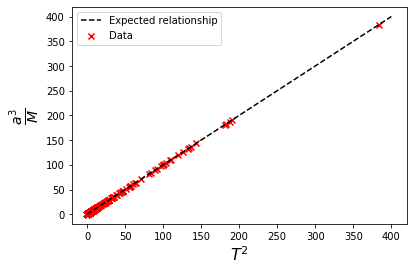

In [10]:
# We are aware of the presence of NaNs in the array
# and they are going to be handled by matplotlib, 
# so we can safely ignore the warning for NaNs
np.seterr(invalid="ignore")

"""
After the first two lines, all of the data for each object is contained 
on one line separated by commas, starting with the name of the object.
Therefore, we want to extract the second, third, and fourth item on each
line, which will be MSTAR, A, and PER respectively.
"""
mstar = np.array([])
A = np.array([])
period = np.array([])
data = np.genfromtxt("exoplanets.csv", skip_header = 2, delimiter = ',')

for line in data:
    line[3] /= 365    # convert days to years for proportionality constant of 1
    if line[3] < 20:    # only want periods less than 20 years
        mstar = np.append(mstar, line[1])
        A = np.append(A, line[2])
        period = np.append(period, line[3])

y_axis = (A**3)/mstar

plt.scatter(np.square(period), y_axis, color = 'r', marker = 'x', label = 'Data')
# plot the line y = x
plt.plot(np.linspace(0, 400, 100), np.linspace(0, 400, 100), 'k--', label = 'Expected relationship')
plt.xlabel("${T^{2}}$", fontsize = 16)
plt.ylabel("$\\frac{a^{3}}{M}$", fontsize = 20)
plt.legend()
plt.show()

As is evident by the plot, the two data sets follow a linear relation, verifying the proportionality proposed by Kepler's Third Law.

---

# Waves in 2-D

The equation
$$z(x,y) = z_0\sin\left(k\sqrt{x^2+y^2}-\omega t\right)$$
describes a circular set of waves centered on the origin that propagate outwards as time progresses. This program creates an animated representation of this wave.

For the parameters, I will be assuming $z_0=1$ and $k=1$ (so that the units are as simple as possible), with the wave centered at the origin.

In [11]:
fig = plt.figure()
pbar = display.ProgressBar(125)    # 125 to match with frame count (see comment below)
pbar.display()

# Generate x and y coordinates of a circle
x_set = np.linspace(-2*np.pi, 2*np.pi, 151)
y_set = np.linspace(-2*np.pi, 2*np.pi, 151)
# create meshgrid to properly map to z values for each xy point
x, y = np.meshgrid(x_set, y_set)

# t = 0 state for the wave
z = np.sin(np.sqrt(x**2+y**2))

plt.axis("scaled")
plt.xlim(-150, 150)
plt.ylim(-150, 150)
image = plt.imshow(z, extent = (-150, 150, -150, 150))

def animate(frame):
    # the frame count serves as our time dependence for the wave
    z = np.sin(np.sqrt(x**2+y**2)-frame/10)    # changing frequency to slow down the animation
    image.set_data(z)
    pbar.progress = frame+1
    
# 125 frames produces a smooth loop
anim = FuncAnimation(fig, animate, frames=125, interval=20)

# The following lines present a general purpose method of
# converting an animation to a playable video and displaying
# that video. This code will appear in the same form in future programs.
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

[============================================================] 125/125

---

# Diffusion-Limited Aggregation

Brownian motion is the motion of a particle, such as a smoke or dust particle, in a gas, as it is buffeted by random collisions with gas molecules. The first part of this simulation is of such a particle in two dimensions as follows. In general, the particle is confined to a square grid or lattice $L\times L$ squares on a side, so that its position can be represented by two integers. It starts in the middle of the grid. On each step of the simulation, a random direction - up, down, left, or right - is chosen, and the particle is moved one step in that direction, i.e. a random walk.

For this demonstration, 100 steps of this process on a lattice with $L=25$ will be performed, and an animation will plot the position of the particle at each step. If the particle hits a wall, it will bounce off the wall in the opposite direction.

In [12]:
fig = plt.figure()
pbar = display.ProgressBar(100)
pbar.display()
    
lines = plt.plot(0, 0, 'o')     # starting in the center
point = lines[0]

plt.axis("scaled")
plt.xlim(-12, 12)    # for a 25x25 grid with 0,0 at the center, the max coordinate for either x or y is 12
plt.ylim(-12, 12)

plt.grid(linewidth = 1)

def animate(frame):
    x = point.get_xdata()
    y = point.get_ydata()
    # generate a number from 1-4 to represent moving in one of the four possible directions
    next_step = random.randint(1, 4)
    
    if(next_step == 1):
        if(point.get_ydata() == 12):
            # bounce off
            point.set_ydata(y - 1)
        else:
            # move up
            point.set_ydata(y + 1)
    elif(next_step == 2):
        if(point.get_xdata() == 12):
            # bounce off
            point.set_xdata(x - 1)
        else:
            # move right
            point.set_xdata(x + 1)
    elif(next_step == 3):
        if(point.get_ydata() == -12):
            # bounce off
            point.set_ydata(y + 1)
        else:
            # move down
            point.set_ydata(y - 1)
    elif(next_step == 4):
        if(point.get_xdata() == -12):
            # bounce off
            point.set_xdata(x + 1)
        else:
            # move left
            point.set_xdata(x - 1)
    
    pbar.progress = frame+1

anim = FuncAnimation(fig, animate, frames=100, interval=100)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

[============================================================] 100/100

Next, I will be reproducing one a famous model in computational physics, [diffusion-limited aggregation](https://en.wikipedia.org/wiki/Diffusion-limited_aggregation), or DLA for short. There are various versions of DLA, but the one in this program is as follows. Take a square grid with a single particle in the middle. The particle performs a random walk from square to square on the grid until it reaches a point on the edge of the system, at which point it "sticks" to the edge, becoming anchored there and immovable. Then a second particle starts at the center and does a random walk until it
sticks either to an edge or to the other particle. Then a third particle starts, and so on. Each particle starts at the center and walks until it sticks either to an edge or to any anchored particle.


The general concept of the walk in this case is very similar to the previous bit of code for the random walk. This time, a $101 \times 101$ grid will be used. New particles will be created at the center of the grid, whereupon they will walk randomly until they stick to either an edge or another anchored particle.

For the sake of speed (both of runtime and the animation itself), the particles will only be shown on screen once they are anchored. The entire path of each random walk will not be animated.

The program is set up so that it generates a total of 1000 particles (corresponding to 1000 frames of animation).

In [13]:
# Represent the border and any anchored particles with a boolean (i.e. 1 or 0) matrix.
# Initialize to False, then make all of the borders True so that particles
# will anchor to the border by default.
fixed_points = np.zeros((101, 101), bool)
fixed_points[0] = np.ones(101, bool)
fixed_points[100] = np.ones(101, bool)
fixed_points[:, 0] = np.ones((1, 101), bool)
fixed_points[:, 100] = np.ones((1, 101), bool)

fig = plt.figure()
pbar = display.ProgressBar(1000)
pbar.display()

plt.axis("scaled")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.grid(linewidth = 1)

def needs_anchor(x, y):
    """
    Determines if any of the neighboring spots are occupied.
    If so, sum will be non-zero, meaning the logical negation of it 
    will break out of the while loop.
    Input: indices of matrix corresponding to xy coordinate of current particle
    """
    return fixed_points[x][y-1] + fixed_points[x+1][y] + fixed_points[x][y+1] + fixed_points[x-1][y]


"""
Matrix elements are indexed starting at the top left corner, whereas our grid has (0, 0) in the center.
Thus, indexing the matrix in the following way will map our particle's coordinates to the appropriate indices.
With coordinates, it's (column, row), i.e. (x, y),
but with matrix indexing, it's [row][column], which is equivalent to [y][x]
e.g. (-50, 50) -> [0][0], (-50, -50) -> [100][0], (50, 50) -> [0][100]
"""
def calculate_path(point):
    # Data getters for Line2d object return lists. 
    # Index it to just get the integer typed data,
    # which in this case is the only element of each list.
    x = point.get_xdata()[0]
    y = point.get_ydata()[0]

    # See above paragraph to explain offsets of 50
    while(not needs_anchor(x+50, 50-y)):    
        next_step = random.randint(1, 4)
        if(next_step == 1):
            # move up
            y += 1
        elif(next_step == 2):
            # move right
            x += 1
        elif(next_step == 3):
            # move down
            y -= 1
        elif(next_step == 4):
            # move left
            x -= 1
    
    # by now, the particle has encountered either a wall or another particle,
    # so fix it in place
    fixed_points[50-y][x+50] = True
    return (x, y)
                                            
def animate(frame):
    lines = plt.plot(0, 0, 'o')
    point = lines[0]
    final_x, final_y = calculate_path(point)
    # just plot final position rather than the path, to save on runtime and animation length
    point.set_data((final_x, final_y))
    pbar.progress = frame+1

# 1000 frames ==> 1000 particles/random walks generated
anim = FuncAnimation(fig, animate, frames=1000, interval=20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

[============================================================] 1000/1000

---

In [14]:
# This code downloads the file from the Internet and saves it in the working directory
if not os.path.isfile("stm.txt"):
    url.urlretrieve("http://www.pitt.edu/~djn23/phys1321/stm.txt", "stm.txt")

# Calculating Shadows


The file "stm.txt" contains an [scanning tunneling microscope](https://en.wikipedia.org/wiki/Scanning_tunneling_microscope) image of the surface of silicon, stored as a 2-D array. The goal of this program is to enhance the image by calculating how it would look illuminated by a fixed light source.

When light strikes a surface, the amount falling per unit area depends not only on the intensity of the light, but also on the angle of incidence. The resulting intensity of illumination is $a\cos\theta$, where $a$ is the raw
intensity of the light. This simple physical law allows us to calculate how light falls on three-dimensional objects and hence how they will look when illuminated from various angles.

Suppose, for instance, that we are looking down on the silicon from above. We know the height of the surface $w(x,y)$ as a function of position in the plane, so the equation for the surface is simply $z=w(x,y)$, or equivalently $z-w(x,y)=0$, and the normal
vector $\vec{v}$ to the surface is given by the gradient of $z-w(x,y)$ thus:

$$\vec{v} = \vec{\nabla} [z-w(x,y)] = \begin{pmatrix}\partial/\partial x \\ \partial/\partial y \\ \partial/\partial z \end{pmatrix} [z-w(x,y)] = \begin{pmatrix}-\partial w/\partial x \\ -\partial w/\partial y \\ 1 \end{pmatrix}\,.$$

Now suppose we have light coming in represented by a vector $\vec{a}$ with magnitude equal to the intensity of the light. Then the dot product of the vectors $\vec{a}$ and $\vec{v}$ is

$$\vec{a}\cdot\vec{v} = |\vec{a}|\,|\vec{v}|\cos\theta\,,$$

where $\theta$ is the angle between the vectors. Thus the intensity of illumination of the surface is

$$I = |\vec{a}| \cos\theta = \frac{\vec{a}\cdot\vec{v}}{|\vec{v}|} = \frac{-a_x (\partial w/\partial x) - a_y (\partial w/\partial y) + a_z}{\sqrt{(\partial w/\partial x)^2 + (\partial w/\partial y)^2 + 1}}\,.$$

In turn, the illumination can be expressed in terms of a pair of angles that describe the location of the sun in the sky:

$$\vec{a}=(\cos\theta\cos\phi,\cos\theta\sin\phi,\sin\theta)\,,$$

where $\theta$ represents the altitude angle, and $\phi$ represents the azimuthal angle (measured counterclockwise from the $+x$-axis).

Numpy's `gradient` function can be used to calculate the derivatives $\partial w/\partial x$ and $\partial w/\partial y$ at each grid point. To get the scaling right, we'll need to use the distance between grid points, which is about 2.5 (arbitrary units) in this case.

This program will calculate the intensity for each grid point assuming that the incident light is coming in at angles $\theta=20^\circ$ and $\phi=30^\circ$. To show the image, I'll make a density plot of the resulting values in which the brightness of each dot depends on the corresponding intensity value.

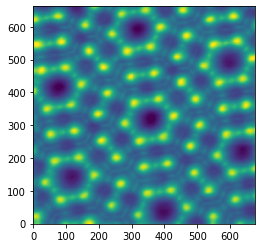

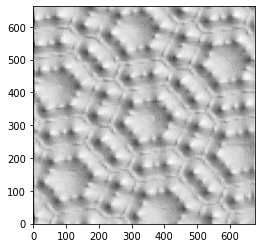

In [15]:
# convert to radians
theta = 20*np.pi/180
phi = 30*np.pi/180

# known formulas for converting from polar coordinates to cartesian coordinates
a_x = np.cos(theta)*np.cos(phi)
a_y = np.cos(theta)*np.sin(phi)
a_z = np.sin(theta)

# load stm data
w = np.loadtxt("stm.txt")

# np.gradient returns the directional derivatives as (d/dy, d/dx)
dwdy, dwdx = np.gradient(w, 2.5)

# use formula from above
I = (-a_x*dwdx - a_y*dwdy + a_z)/(np.sqrt(dwdx**2 + dwdy**2) + 1)

# compare raw data with data after the light source has been "shone" on it
plt.imshow(w, origin = 'lower')
plt.show()
plt.imshow(I, cmap = 'gray', origin = 'lower')
plt.show()

---

# Eigenfrequencies

Consider a chain of four identical masses connected by five ideal springs. Neglect the effects of gravity for simplicity. In this program, I will be making an animation that shows the chain vibrating horizontally at each of its four *eigenfrequencies* (neglecting the effects of gravity, for simplicity).

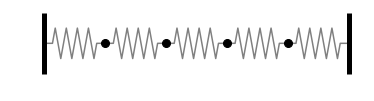

Let $x_0$, $x_1$, $x_2$, and $x_3$ be the horizontal displacement of each mass from equilibrium, numbered from left to right. (For example, in the figure above, $x_0 = x_1 = x_2 = x_3 = 0$. The potential energy of the chain is

$$U = \tfrac12 k x_0^2 + \tfrac12 k(x_1-x_0)^2 + \tfrac12 k(x_2-x_1)^2 + \tfrac12 k(x_3-x_2)^2 + \tfrac12 k x_3^2\,,$$     

where there is one term for each of the five springs.

Using

$$F_j=-\frac{\partial U}{\partial x_j} = m\ddot{x_j}\,,$$

one can obtain the four equations of motion that govern the four masses by substituting in $U$ and evaluating for each possible value of $j$. 

To find the eigenfrequencies $\omega$ of the system, we exploit the fact that the solution to a simple harmonic oscillator takes the form $\ddot{x_i} = -\omega^2 x_i$.
We can put these four equations into the form of a matrix equation:

$$\mathbf{Mx}=\frac{\omega^2}{\omega_0^2}\mathbf{x}\,,$$

where $\mathbf{M}$ is a matrix with the coefficients from the equation of motion and $\omega_0=\sqrt{k/m}$ is the natural frequency of each spring. Choose units where $\omega_0 = 1$, again for simplicity. The equation as it stands now is a straightforward eigenvalue problem.

$$\mathbf{Mx}=\omega^2\mathbf{x}\,$$

where $\omega$ are the angular *eigenfrequencies*. Since these are the square root of eigenvalues, they must all be real numbers.

To understand the significance of these eigenfrequencies, it is important to recall that the time-dependent solution to a simple harmonic oscillator is the real part of

$$x_j(t) = A_j e^{\mathrm{i}\omega t}\,,$$

where $A_j$ is the complex amplitude. (The complex nature of $A_j$ allows for different phase&mdash;the magnitude of $A_j$ is what we normally call "amplitude".) In other words, when the chain is driven at an arbitrary frequency $\omega$, all four masses move with that same frequency, but different amplitudes and phases. In general, the values of these amplitudes and phases are not obvious.

However, if the system is driven at an eigenfrequency, the resulting amplitudes are all real, and the amplitudes of the four masses are exactly the elements of the associated eigenvector.

The following program will make an animation that shows the chain moving at each of its four eigenfrequencies.

In [16]:
# The following two functions are used for drawing the springs
# The springs consist of a series of 5 zig-zags with black
# dots separating them and black bars bookending

def draw_spring(left, right):
    """
    Draws a horizontal spring.
    Inputs: left  = x-coord of left side
            right = x-coord of right side
    """
    dy = 0.5
    x = np.linspace(left, right, 23)
    y = np.array([0]*4 + [dy, 0, -dy, 0]*4 + [0]*3) # zig-zag shape for spring
    spring = plt.Line2D(x, y, linestyle="-", color="gray", zorder=-1)
    ax = plt.gca()                      #                        ^
    ax.add_line(spring)                 # draw behind everything else


def draw_chain(x_offsets):
    """
    Draw a chain of five springs and four masses.
    Input: x_offsets = list of displacements from equilibrium
    """
    x = np.arange(2, 10, 2) + x_offsets
    #print(x)
    
    # draw springs
    draw_spring(0, x[0],)
    draw_spring(x[0], x[1])
    draw_spring(x[1], x[2])
    draw_spring(x[2], x[3])
    draw_spring(x[3], 10)
    
    # draw masses
    plt.plot(x, [0, 0, 0, 0], "ko", ms=8)
    
    # draw vertical bars at edges
    plt.vlines([0, 10], -1, 1, "k", lw=5)

In [17]:
fig = plt.figure()
plt.axis("scaled")
pbar = display.ProgressBar(100)
pbar.display()

# matrix determined from finding the four partial derivatives from the first equation
M = np.array([[2, -1, 0, 0],
              [-1, 2, -1, 0],
              [0, -1, 2, -1],
              [0, 0, -1, 2]])

# Use scipy's linalg module to solve the eigenvalue equation
omega_2, eigvecs = linalg.eigh(M)
omega = np.sqrt(omega_2)

# linalg.eigh() returns the eigenvectors as the columns of a matrix.
# Transpose the matrix for ease of access to the components of each eigenvector
A = eigvecs.T

def animate(frame):
    # The value by which the frame counts are divided was chosen to
    # slow down the animations.
    # Also I set the axis ticks to be empty rather than just turning off
    # the axes so that I could put labels under the third and fouth modes,
    # and then I thought that the boxes look neater so I kept them on all four.
    
    
    fig.clear()
    # plot each eigenfrequency in its own subplot for ease of viewing
    # in comparison to the other eigenfrequencies
    plt.subplot(221)
    plt.title("First Mode")
    plt.xticks([])
    plt.yticks([])
    # A[0] is first eigenvector, A[1] is the second, etc.
    x0_t = A[0][0]*np.cos(omega[0]*frame/10)  # cosine is the real part of e^(iωt), which is the part we want
    x1_t = A[0][1]*np.cos(omega[0]*frame/10)
    x2_t = A[0][2]*np.cos(omega[0]*frame/10)
    x3_t = A[0][3]*np.cos(omega[0]*frame/10)
    draw_chain([x0_t, x1_t, x2_t, x3_t])
    
    plt.subplot(222)
    plt.title("Second Mode")
    plt.xticks([])
    plt.yticks([])
    # second eigenfrequency
    x0_t = A[1][0]*np.cos(omega[1]*frame/10)
    x1_t = A[1][1]*np.cos(omega[1]*frame/10)
    x2_t = A[1][2]*np.cos(omega[1]*frame/10)
    x3_t = A[1][3]*np.cos(omega[1]*frame/10)
    draw_chain([x0_t, x1_t, x2_t, x3_t])
    
    plt.subplot(223)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Third Mode", fontsize = 13)
    # third eigenfrequency
    x0_t = A[2][0]*np.cos(omega[2]*frame/10)
    x1_t = A[2][1]*np.cos(omega[2]*frame/10)
    x2_t = A[2][2]*np.cos(omega[2]*frame/10)
    x3_t = A[2][3]*np.cos(omega[2]*frame/10)
    draw_chain([x0_t, x1_t, x2_t, x3_t])
    
    plt.subplot(224)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Fourth Mode", fontsize = 13)
    # fourth eigenfrequency
    x0_t = A[3][0]*np.cos(omega[3]*frame/10)
    x1_t = A[3][1]*np.cos(omega[3]*frame/10)
    x2_t = A[3][2]*np.cos(omega[3]*frame/10)
    x3_t = A[3][3]*np.cos(omega[3]*frame/10)
    draw_chain([x0_t, x1_t, x2_t, x3_t])
    pbar.progress = frame + 1
    
anim = FuncAnimation(fig, animate, frames=100, interval=20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

[============================================================] 100/100

---

# Lagrange Points

The [Lagrange points](https://en.wikipedia.org/wiki/Lagrangian_point) are the five points located around a pair of celestial bodies where the net gravitational field is exactly zero as measured in a co-rotating reference frame (i.e. accounting for the non-inertial centrifugal force). The goal of the next program is to calculate the five Lagrange points for the Earth-Moon system.

In a reference frame that rotates about the earth-moon system's center of mass, the effective gravitational potential is

$$V=-\frac{GM}{r_E} - \frac{Gm}{r_m} - \tfrac12 r^2 \omega^2\,$$

where $G=6.674\times10^{-11}$ m$^3$kg$^{-1}$s$^{-2}$, $M=5.974\times10^{24}$ kg is the mass of the earth, $m=7.348\times10^{22}$ kg is the mass of the moon, and $\omega=2.662\times10^{-6}$ s$^{-1}$ is the orbital angular frequency of the moon about the earth-moon system's center of mass. Note that the third term above is the *centrifugal force* introduced by working in co-rotating coordinates. The three distances $r_E$, $r_m$, and $r$ are measured **from** the earth, moon, and center of mass, respectively. To convert between cartesian and polar coordinates, one can use 

$$r = \sqrt{x^2 + y^2}\,,$$

$$r_E = \sqrt{(x-x_E)^2 + (y-y_E)^2}\,,$$

and

$$r_m = \sqrt{(x-x_m)^2 + (y-y_m)^2}\,,$$

where $(x_E, y_E)$ and $(x_m, y_m)$ are the locations of the earth and moon. It is important to note that the Earth-moon system orbits around its center of mass, not the Earth's center, so (0,0) coincides with the center of mass. Thus, the location of the earth and moon can be calculated by the fact that the radius of the moon's orbit is $R=3.844\times10^8$ m.

Finally, the gravitation field is given by
    
$$\vec{F}=-\vec{\nabla}V\,.$$
    
The five locations where $|\vec{F}|=0$, are called the **Langrange Points**. In principle, an object placed there could remain stationary relative to the earth and moon. (In practice only $L_4$ and $L_5$ are stable once small perturbations are considered).

This program will make a plot of the Earth-moon system, the contours of the gravitational potential of said system, and the 5 labeled Lagrangian Points.

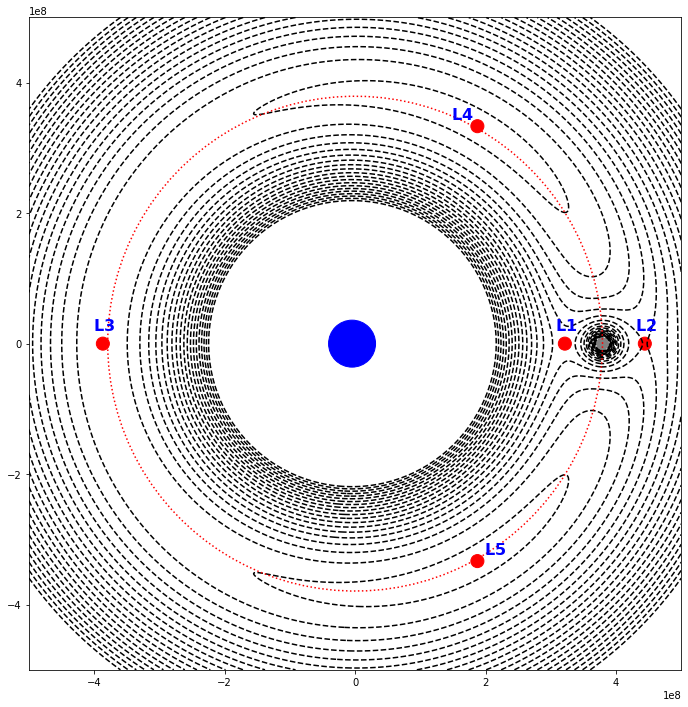

In [18]:
plt.figure(figsize = (12, 12))

# ALL DISTANCES ARE IN METERS

# Set up constants x-coordinate of Earth and moon (since y = 0)
E_center = -4670000    # Distance from Earth's center to the center of mass of the Earth-moon system
moon_center = -4670000+384000000    # Aforementioned distance plus the given distance b/w Earth and moon
G = 6.674e-11
M = 5.974e24
m = 7.348e22
w = 2.662e-6

earth = plt.Circle((E_center, 0), radius = 36000000, color = 'blue')
moon = plt.Circle((moon_center, 0), radius = 9000000, color = 'gray')

# make plot to scale so that no constants have to be altered
x_ = np.linspace(-5e8, 5e8, 1000)
y_ = np.linspace(-5e8, 5e8, 1000)
x, y = np.meshgrid(x_, y_)

# convert from cartesian to polar for calculations
r = np.sqrt(x**2 + y**2)
r_E = np.sqrt((x-E_center)**2 + y**2)
r_m = np.sqrt((x-moon_center)**2 + y**2)

# potential function as given above
V = -(G*M/r_E) - (G*m/r_m) - 0.5*(r**2)*(w**2)


def F(xy):
    """
    Use the analytically calculated gradient of V and the x and y coordinates
    to calculate the x and y components of the gravitational force from the 
    Earth, moon, and centrifugal force. Then, sum these all up to get the 
    total components of the gravitational force at each point in the grid.
    """
    x, y = xy
    r = np.sqrt(x**2 + y**2)
    r_E = np.sqrt((x-E_center)**2 + y**2)
    r_m = np.sqrt((x-moon_center)**2 + y**2)
    
    f = r*w**2
    theta = np.arctan2(y, x)
    fx = f*np.cos(theta)
    fy = f*np.sin(theta)
    
    f_e = -G*M/(r_E**2)
    theta_e = np.arctan2(y, (x-E_center))
    fx_e = f_e*np.cos(theta_e)
    fy_e = f_e*np.sin(theta_e)
    
    f_m = -G*m/(r_m**2)
    theta_m = np.arctan2(y, (x-moon_center))
    fx_m = f_m*np.cos(theta_m)
    fy_m = f_m*np.sin(theta_m)
    
    Fx = fx + fx_e + fx_m
    Fy = fy + fy_e + fy_m
    F = np.sqrt(Fx**2 + Fy**2)
    return F

# Guesses for Lagrange Point coordinates based on comparing the locations of the points on
# reference pictures, relative to their contour lines, to the contour lines on my graph.
# As described above, these points occur at 0 net force, so we want to minimize the force
# around where the points should be.
L1 = optimize.minimize(F, (3e8, 0), method = 'Powell')
L2 = optimize.minimize(F, (4e8, 0), method = 'Powell')
L3 = optimize.minimize(F, (-3e8, 0), method = 'Powell')
L4 = optimize.minimize(F, (2e8, 3e8), method = 'Powell')
L5 = optimize.minimize(F, (2e8, -3e8), method = 'Powell')

# To make the locations of the points more obvious, represent them as filled red circles
L1 = plt.Circle((L1.x[0], L1.x[1]), radius = 1e7, color = 'red')
L2 = plt.Circle((L2.x[0], L2.x[1]), radius = 1e7, color = 'red')
L3 = plt.Circle((L3.x[0], L3.x[1]), radius = 1e7, color = 'red')
L4 = plt.Circle((L4.x[0], L4.x[1]), radius = 1e7, color = 'red')
L5 = plt.Circle((L5.x[0], L5.x[1]), radius = 1e7, color = 'red')

ax = plt.gca()
plt.axis("scaled")
plt.xlim(-5e8, 5e8)
plt.ylim(-5e8, 5e8)

# plot earth and moon representations
ax.add_patch(earth)
ax.add_patch(moon)

# add each of the Lagrange points to the plot, along with labels placed in the
# most convenient spots I could find given the contours
ax.add_patch(L1)
plt.text(L1.center[0]-0.15e8, 0.2e8, r"$\bf{L1}$", fontsize = 16, color = 'blue')
ax.add_patch(L2)
plt.text(L2.center[0]-0.15e8, 0.2e8, r"$\bf{L2}$", fontsize = 16, color = 'blue')
ax.add_patch(L3)
plt.text(L3.center[0]-0.15e8, 0.2e8, r"$\bf{L3}$", fontsize = 16, color = 'blue')
ax.add_patch(L4)
plt.text(L4.center[0]-0.4e8, L4.center[1]+0.1e8, r"$\bf{L4}$", fontsize = 16, color = 'blue')
ax.add_patch(L5)
plt.text(L5.center[0]+0.1e8, L5.center[1]+0.1e8, r"$\bf{L5}$", fontsize = 16, color = 'blue')

# Plot the path of the moon's orbit as a dashed red line
t = np.linspace(0, 2*np.pi, 100)
a_moon = (384000000-4670000)
plt.plot(a_moon*np.cos(t), a_moon*np.sin(t), 'r:')

# Plot contours with sufficient spacing such that the presence of the Lagrange points can be seen in them.
# Also, no need to show V all the way up to the Earth, as no meaningfuly information is gained for our purposes here.
plt.contour(V, levels = np.linspace(-2000000, -900000, 50), colors = 'k', extent = (-5e8, 5e8, -5e8, 5e8))
plt.show()

---

# Fourier Transform of Sound

To begin this demonstration of Fourier transforms, I'll be using the following sample waveform of a trumpet playing a C$_5$ (523.251 Hz).

In [19]:
# This code downloads the file from the Internet and saves it in the working directory
if not os.path.isfile("trumpet.txt"):
    url.urlretrieve("http://www.pitt.edu/~djn23/phys1321/trumpet.txt", "trumpet.txt")

In [20]:
trumpet = np.loadtxt("trumpet.txt")
display.Audio(trumpet, rate = 44100)

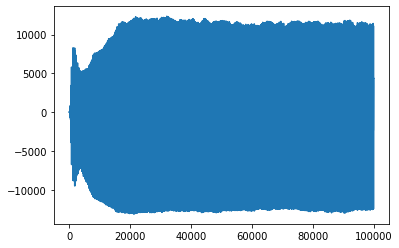

In [21]:
l = len(trumpet)
plt.plot(np.linspace(0, l, l), trumpet)
plt.show()

Next, I'll calculate the Fourier transform of the trumpet's waveform and create a plot of the **power spectrum** of the Fourier coefficients ($|c_k|^2$) for frequencies between zero and 4000 Hz. As you'll be able to see in the graph, there are peaks at multiples 523.251 Hz, which are the **harmonics** of the note being played.

I have plotted several vertical lines spaced at intervals of 523.251 Hz to verify this visually.

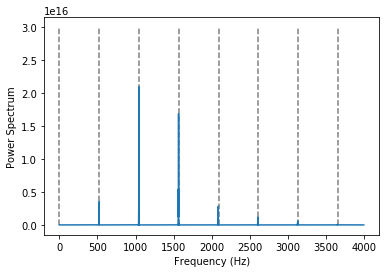

In [22]:
# perform Fourier transform on waveform data
c = fftpack.fft(trumpet)

# definition of power spectrum from Fourier coefficients
power_spectrum = abs(c)**2

# make spacing the resolution of the Nyquist frequency for most accuracy
freq = np.arange(0, 4000, 44100/100000)

# Only plotting frequencies up to 4 kHz
plt.plot(freq, power_spectrum[0:len(freq)])
# Plot vlines at intervals of 523.251 to verify harmonics
plt.vlines(np.arange(0, 4000, 523.251), ymin = 0, ymax = 3e16, colors = 'gray', linestyles = 'dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')
plt.show()

Now I'll be looking at a more complicated waveform.

In [23]:
# Download the file `StarWars.wav` (if it does not exist in the working directory), and verify that it plays.
if not os.path.isfile("StarWars.wav"):
    url.urlretrieve("http://www.pitt.edu/~djn23/phys1321/StarWars.wav", "StarWars.wav")

display.Audio("StarWars.wav")

Although the audio clip is 8 seconds long, for simplicity's sake I'll be looking just at the first chord of the piece and trying to determine what chord it is using a Fourier transform.

As before, the sampling rate will assumed to be the default of 44100. I'll be splicing the data to try to narrow it down to just the first note, and then plot the power spectrum of the Foueri coefficients.

For determining notes from frequencies, I'll be using [this page as a resource](https://en.wikipedia.org/wiki/Piano_key_frequencies). I expect there to be certain peaks that are noticably more prominent than some others, so I'll mainly focus on identifiying those and ones that are repeat occurances of the same note but in different octaves (i.e. notes that are almost certainly in the chord, rather than a one-off note).

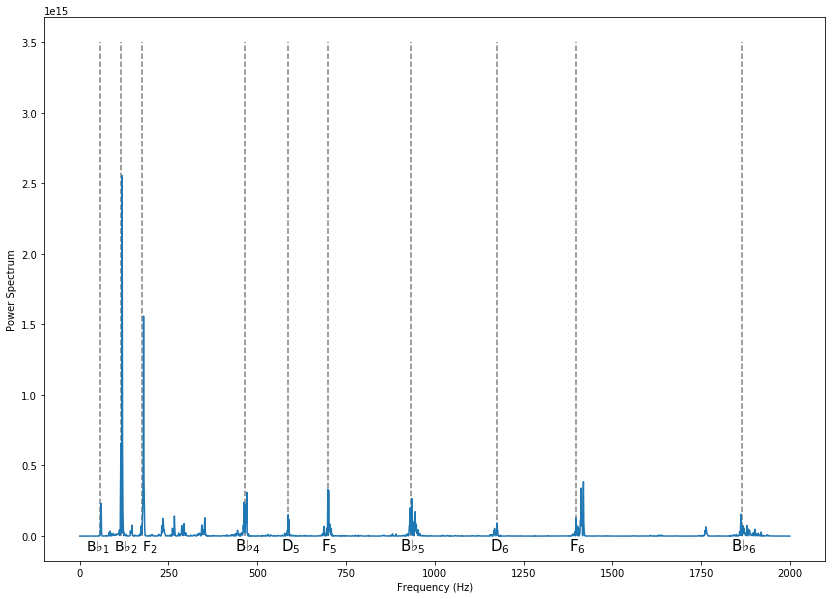

In [24]:
plt.figure(figsize = (14, 10))

# use scipy's wavread to get the data and sampling rate in one go
rate, data = wavread('StarWars.wav')

# splicing range was determined by approximating and testing certain ranges based on
# the length of the audio file
old_l = len(data)
l = old_l/6
new_data = data[18600:int(l)]

# Same method for the Fourier transform and power spectrum as with the trumpet.
# I'll only be plotting up to 2 kHz this time.
c_k = fftpack.fft(new_data)
spectrum = abs(c_k)**2
freqs = np.arange(0, 2000, 44100/len(spectrum))
plt.plot(freqs, spectrum[0:len(freqs)])

"""
 Notes were determined by plotting the spectrum, looking for where there were noticable peaks,
 and seeing which frequencies on the reference page where around the plotted frequencies. I then
 plotting vlines at the frequencies of those notes to make sure that they lined up. The names of
 the notes were also found from the same web page.
"""
notes = [58.27047, 116.5409, 174.6141, 466.1638, 587.3295, 698.4565, 932.3275, 1174.659, 1396.913, 1864.655]
#notes:  Bflat_1   Bflat_2     F_3     Bflat_4      D_5      F_5      Bflat_5     D_6      F_6      Bflat_6


plt.vlines(notes, ymin = 0, ymax = 3.5e15, colors = 'gray', linestyles = 'dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')

# Plot labels for the most prominent notes, using proper notation and naming conventions.
plt.text(notes[0]-40, -0.1e15, "$\mathregular{B♭_1}$", fontsize = 14)
plt.text(notes[1]-20, -0.1e15, "$\mathregular{B♭_2}$", fontsize = 14)
plt.text(notes[2], -0.1e15, "$\mathregular{F_2}$", fontsize = 14)
plt.text(notes[3]-30, -0.1e15, "$\mathregular{B♭_4}$", fontsize = 15)
plt.text(notes[4]-20, -0.1e15, "$\mathregular{D_5}$", fontsize = 15)
plt.text(notes[5]-20, -0.1e15, "$\mathregular{F_5}$", fontsize = 15)
plt.text(notes[6]-30, -0.1e15, "$\mathregular{B♭_5}$", fontsize = 15)
plt.text(notes[7]-20, -0.1e15, "$\mathregular{D_6}$", fontsize = 15)
plt.text(notes[8]-20, -0.1e15, "$\mathregular{F_6}$", fontsize = 15)
plt.text(notes[9]-30, -0.1e15, "$\mathregular{B♭_6}$", fontsize = 15)

plt.show()

Based on the prominence of the notes B$_♭$, D, and F, it seems that the first chord of the ever-famous Star Wars theme is a B$_♭$ major chord.

---

# Double Pendulum

A double pendulum consists of a normal pendulum with another pendulum hanging from its end. For simplicity I will be ignoring friction and assuming that both pendulums have bobs of the same mass $m$ and massless arms of the same length $\ell$. Thus the setup looks like this:

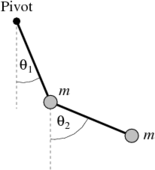

The position of the arms at any moment in time is uniquely specified by the two angles $\theta_1$ and $\theta_2$.  The equations of motion for the angles are most easily derived using the Lagrangian formalism. The resulting pair of equations are

$$\begin{align}
2\ddot\theta_1 + \ddot\theta_2 \cos(\theta_1-\theta_2) &+ \dot\theta_2^2 \sin(\theta_1-\theta_2) + 2{g\over\ell} \sin\theta_1 = 0\,,\\
\ddot\theta_2 + \ddot\theta_1 \cos(\theta_1-\theta_2) &- \dot\theta_1^2 \sin(\theta_1-\theta_2) + {g\over\ell} \sin\theta_2 = 0\,.
\end{align}$$

These are second-order equations, but they can be converted into first-order ones by defining two new variables, $\omega_1$ and $\omega_2$, thus:

$$\dot\theta_1 = \omega_1,\qquad \dot\theta_2 = \omega_2\,.$$

In terms of these variables the equations of motion become

$$\begin{align}
2\dot\omega_1 + \dot\omega_2 \cos(\theta_1-\theta_2) &+ \omega_2^2 \sin(\theta_1-\theta_2) + 2{g\over\ell} \sin\theta_1 = 0\,,\\
\dot\omega_2 + \dot\omega_1 \cos(\theta_1-\theta_2) &- \omega_1^2 \sin(\theta_1-\theta_2) + {g\over\ell} \sin\theta_2 = 0\,.
\end{align}$$

Finally, these can be rearranged into the standard form with a single derivative on the left-hand side of each one, which gives

$$\begin{align*}
\dot\omega_1 &= - {\omega_1^2\sin(2\theta_1-2\theta_2) + 2\omega_2^2\sin(\theta_1-\theta_2) + (g/\ell) \bigl[ \sin(\theta_1-2\theta_2) + 3 \sin\theta_1 \bigr]\over 3 - \cos(2\theta_1-2\theta_2)}, \\ \\
\dot\omega_2 &= {4\omega_1^2\sin(\theta_1-\theta_2) + \omega_2^2\sin(2\theta_1-2\theta_2) + 2(g/\ell) \bigl[ \sin(2\theta_1-\theta_2) - \sin\theta_2 \bigr]\over 3 - \cos(2\theta_1-2\theta_2)}.
\end{align*}$$

These two equations, along with the equations $\dot{\theta}_1=\omega_1$ and $\dot{\theta}_2=\omega_2$, give four first-order equations which between them define the motion of the double pendulum.

The first part of this program will solve the equations of motion from $t=0$ to $t=60$ seconds for the case where $\ell=0.4$ metters, with the initial conditions $\theta_1=\theta_2=\pi$ rad, $\omega_1=0$, and $\omega_2=0.001$ rad/s.

Additionally, it will find the mechanincal energy of the system over time, which is described by the equation

  $$E = m\ell^2 \bigl[ \omega_1^2 + \tfrac12 \omega_2^2 + \omega_1\omega_2 \cos(\theta_1-\theta_2) \bigr] - mg\ell(2\cos\theta_1 + \cos\theta_2)\,.$$

(Assume that there is a mass of $m=1$ kg)

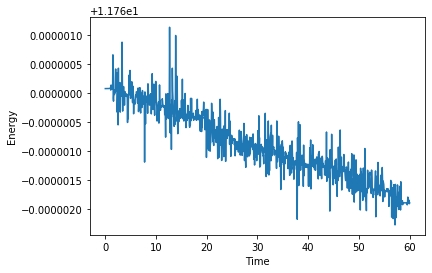

In [25]:
# Constants and variables as define in the above description
g = 9.8
# 1000 frames of animation
t = np.linspace(0, 60, 1000)
th1_0, th2_0 = np.pi, np.pi
w1_0, w2_0 = 0, 0.001
l = 0.4
m = 1


def f(t, r):
    """
    Takes a tuple of values, r, and uses the method of introducing two new
    variables (mentioned above) to define a new pair of ODEs to solve using scipy.
    """
    th1, th2, w1, w2 = r
    fth1 = w1
    fth2 = w2
    fw1 = -(w1**2*np.sin(2*th1-2*th2) + 2*w2**2*np.sin(th1-th2) + (g/l)*(np.sin(th1-2*th2) + 3*np.sin(th1)))/(3 - np.cos(2*th1-2*th2))
    fw2 = (4*w1**2*np.sin(th1-th2) + w2**2*np.sin(2*th1-2*th2) + (2*g/l)*(np.sin(2*th1-th2) - np.sin(th2)))/(3 - np.cos(2*th1-2*th2))
    return fth1, fth2, fw1, fw2

# Let's let scipy handle these ODEs for us
soln = integrate.solve_ivp(f, (0, 60), (th1_0, th2_0, w1_0, w2_0), t_eval = t, method = 'Radau', rtol = 1e-8)
# The solutions are placed into the attribute 'y'
th1, th2, w1, w2 = soln.y

# Use energy equation above to calulate the energy
E = m*l**2*(w1**2 + 0.5*w2**2 + w1*w2*np.cos(th1-th2)) - m*g*l*(2*np.cos(th1) + np.cos(th2))
plt.plot(t, E)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

What fun would this be without a real-time animation?

In [26]:
fig = plt.figure()
plt.axis("scaled")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
pbar = display.ProgressBar(1000)
pbar.display()

# the initial angles are both pi,
# but because of how I'm calculating x and y,
# subtracting by pi/2 visually puts the pendulum
# standing straight up, which matches the commonly
# seen initial conditions for a double pendulum
x1 = np.cos(th1 - np.pi/2)
y1 = np.sin(th1 - np.pi/2)
x2 = x1 + np.cos(th2 - np.pi/2)
y2 = y1 + np.sin(th2 - np.pi/2)

# represent the pendulum as a line with three points, i.e. two segments of equal length
x = [0, x1[0], x2[0]]
y = [0, y1[0], y2[0]]
pend, = plt.plot([], 'k-o')
    
def animate(frame):
    """
    I've already determined the proper x and y positions for the pendulum
    at a given time using the caluclated angles, so just use frame as an index
    for the coordinate arrays to get each subsequent position of the pendulum.
    """
    new_x = [0, x1[frame], x2[frame]]
    new_y = [0, y1[frame], y2[frame]]
    pend.set_data(new_x, new_y)
    pbar.progress = frame + 1

anim = FuncAnimation(fig, animate, frames=1000, interval=60)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

[============================================================] 1000/1000